In [107]:
from models import *
import torch
import numpy as np
import random

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## Chose model
model_class = PLSegmentationModel
model_path = 'saved_models/default_model_v9_with_more_noise.model'

## Load model
model = model_class.load(model_path)

print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')


Model loaded from: 'saved_models/default_model_v9_with_more_noise.model'
Trainable parameters: 5773


In [119]:
## Synthetic dataset
from models.psf import GuassionPSF
from simulation.grain_PL_simulation import TrainingDataSimulationOptions
from torch_utils.dataset import GeneratedPLOutlineDataset
from torch.utils.data import Dataset

from torchvision import transforms

from torch_utils.transform import BackgroundRemovalNormalize, NormalizeIntensityTrace, SkipFrames, ZScoreNorm
def generate_discrete_gaussian(size, num_steps=100, min_val=-3.0, max_val=3.0) -> torch.Tensor:
    continuous = np.random.normal(size=size)
    bins = np.linspace(-3.0, 3.0, num_steps + 1)
    discretized = np.zeros_like(continuous)
    
    for i in range(num_steps):
        mask = (continuous >= bins[i]) & (continuous < bins[i+1])
        midpoint = (bins[i] + bins[i+1]) / 2
        discretized[mask] = midpoint

    current_range = discretized.max() - discretized.min()
    
    full_range = max_val - min_val
    discretized *= full_range / current_range
    discretized += (min_val + max_val) / 2

    return torch.from_numpy(discretized)

def discrete_normal(mean, std, size):
    continuous_normal = np.random.normal(mean, std, size=size)
    return np.round(continuous_normal)
def discrete_normal_like(array: np.ndarray, mean, std):
    return discrete_normal(mean, std, array.shape)


## 1 Pixel is 200 nm
def get_training_data(length: int = 20) -> Dataset:
    psf = GuassionPSF(2.5)

    factor = 1
    options = TrainingDataSimulationOptions(
        grid_size=256 // factor,
        min_grains=3000 // (2 * factor * factor),
        max_grains=3100 // (2 * factor * factor),
        min_noise=0.05 ,
        max_noise=0.20,
        sample_rate=10,
        seconds=15, ## Decides how many frames each test samples has: total frames = sample_rate * seconds
        min_blinker_transition=0.04,
        max_blinker_transition=0.1,
        min_base_counts=6000,
        max_base_counts=12000,
        min_hole_chance=0.01,
        max_hole_chance=0.1,
        static_prob=0.2,
        min_boundary_dimish=0,    
        max_boundary_dimish=1.0,
        min_blinker_strength=0.005,
        max_blinker_strength=0.08,
        min_blinkers_average=50,
        max_blinkers_average=90,
        psf=psf,
    )

    generated_dataset = GeneratedPLOutlineDataset(length=20, 
                                              sim_options=options, 
                                              transforms=transforms.Compose([
                                                # NormalizeIntensityTrace(),
                                                # SkipFrames(skip=3),
                                                # ZScoreNorm(),
                                              ]),
                                              empty_chance=0.0)

    return generated_dataset

Mean: 130
[86 76 67 ... 76 68 69]


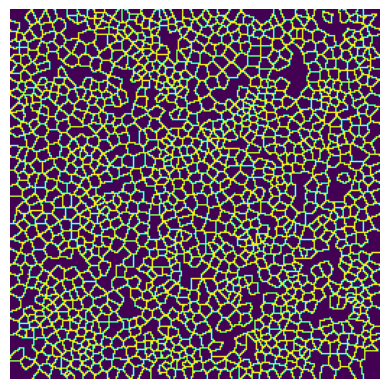

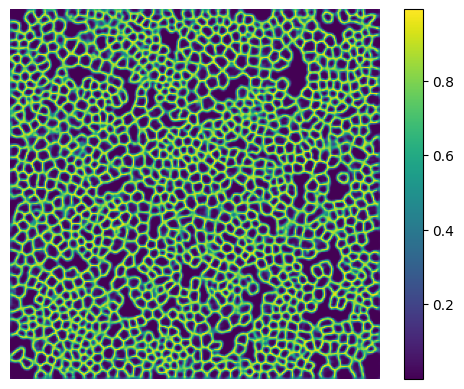

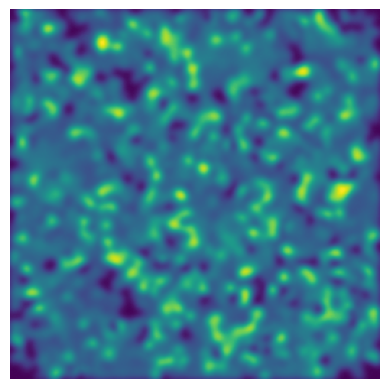

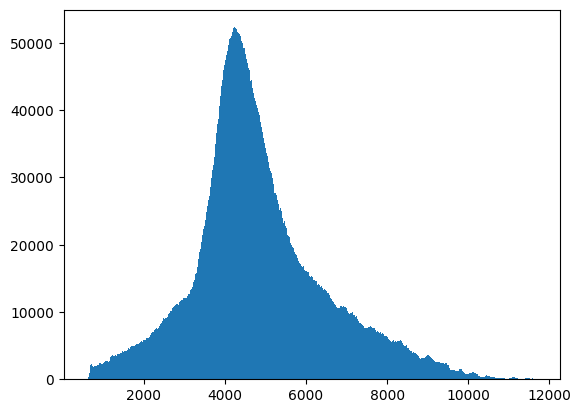

In [120]:
import torch

from data_utils.gif import write_gif
from torch_utils.transform import NormalizeIntensityTrace 

def inference(model: torch.nn.Module, input: torch.Tensor, apply_transforms: bool = False) -> torch.Tensor:
    if apply_transforms:
        f = transforms.Compose(
            [
                NormalizeIntensityTrace(),
                SkipFrames(skip=3),
                # ZScoreNorm(),
                ]
        )
        input = f(input)
    
    with torch.no_grad():
        ## Video data has shape (frames, width, height)
        ## Expected input: (batches, frames, channels, width, height)
        input = input.unsqueeze(0).unsqueeze(2)

        output = model.forward(input, inference=True)

        return output.squeeze(0).squeeze(0)


import matplotlib.pyplot as plt
# set_seed(43)

dataset = get_training_data(20)
# for _ in range(1000):
#     for i in range(20):
video, label = dataset.__getitem__(0)
# discrete_guassian_rand = generate_discrete_gaussian(video.numel(), num_steps=10, min_val=90, max_val=120).reshape(video.shape)

# video = discrete_guassian_rand
# static_grad = np.tile(static_grad, (video.shape[0] * 3, 1, 1))
# video = torch.from_numpy(static_grad)
# video += torch.rand_like(video) * video.max() * 0.00001

output = inference(model, video, apply_transforms=True)

plt.imshow(label)
plt.axis('off')

plt.subplots()

plt.imshow(output)
plt.axis('off')
plt.colorbar()

plt.subplots()

plt.axis('off')
plt.imshow(video[0])

plt.subplots()
plt.hist(video.flatten(), bins=800)
plt.show()



write_gif("test.gif", video, 20, overwrite=True)

In [4]:
# import math


    
    

# mean_dark_current = 367
# hot_pixel_multiplier = 3
# read_noise_sigma = 20

# new_mult = hot_pixel_multiplier * read_noise_sigma

# test_noise = simulate_ccd_noise((200,200,200), 
#                                           mean_dark_current=1000,
#                                           hot_pixel_multiplier=8,
#                                           use_torch=False,).flatten()

# plt.hist(test_noise, bins = 100)
# plt.show()

In [5]:
return

SyntaxError: 'return' outside function (3438313781.py, line 1)

In [98]:
## Load some real data
from data_utils.tiff import tiff_to_array

## small grain
# data = tiff_to_array('data/place1 485nm 50ms excod3.3 emod0 6000 frms air small enhancement _small grain_mv3.tif')

## big grain
data = tiff_to_array('data/place1 485nm 50ms excod3.3 emod0 6000 frms air no enhancement mv4.tif')

## marker
# data = tiff_to_array('data/488nm_OD_exp50ms_500LP_marker.tif')

## Background only, data
# data = tiff_to_array('data/background_measurement.tif')



Inference took 0.39544224739074707 seconds


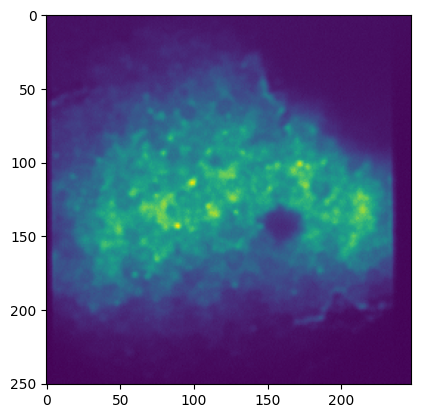

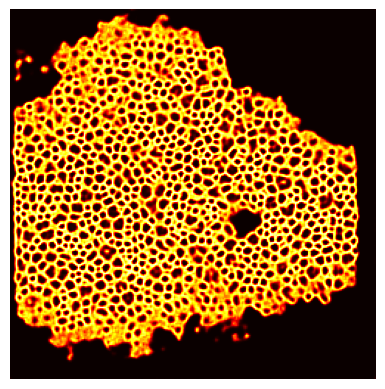

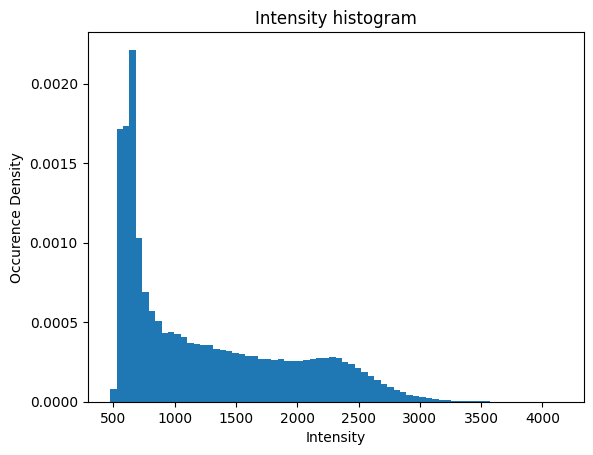

tensor(474.)

In [108]:
import numpy as np
import time

num_frames = 150


sample_video = data[:num_frames, :, :].clone()
mean = sample_video.mean()

# sample_video[sample_video>85] = mean
# sample_video[sample_video<69] = mean

# sample_video = torch.from_numpy(
#     np.random.standard_cauchy(size=sample_video.shape) * 0.05 + 95
# )

# sample_video = video = torch.from_numpy(
#     generate_ccd_noisy_video(sample_video.shape[0], (sample_video.shape[1], sample_video.shape[2]),
#                              hot_pixel_prob=0.06, hot_pixel_multiplier=5)
# )
# sample_video = torch.from_numpy(discrete_normal_like(sample_video, 95, 1)) 
# sample_video = torch.randn_like(sample_video) * 0.5 + 95

first_frame = sample_video[0]

start = time.time()
model_output = inference(model, sample_video, apply_transforms=True)
end = time.time()

print(f'Inference took {end - start} seconds')

## Profile line
scale = 1
x = 150 // scale
y_range = (100 // scale, 255 // scale)


## PL overlay plot
plt.subplots()

plt.imshow(first_frame)

## Transparant map
plt.subplots()

plt.imshow(model_output, cmap='hot')
plt.axis('off')
plt.savefig('test_transparant_map.png', transparent=True, dpi=500)



plt.subplots()
plt.title("Intensity histogram")
plt.xlabel("Intensity")
plt.ylabel("Occurence Density")

output = plt.hist(sample_video.flatten(), bins=70, density=True)
plt.show()

sample_video.flatten().min()

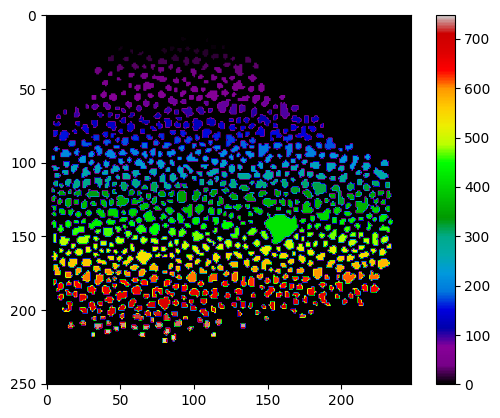

In [111]:
import numpy as np
from skimage import measure, morphology
import matplotlib.pyplot as plt
import torch

def find_largest_cluster(clustered_image):
    # Get unique cluster values and their counts
    unique_values, counts = np.unique(clustered_image[clustered_image > 0], return_counts=True)
    
    # Find the index of the maximum count
    largest_cluster_idx = np.argmax(counts)
    
    # Get the value of the largest cluster
    largest_cluster_value = unique_values[largest_cluster_idx]
    
    # Get the size of the largest cluster
    largest_cluster_size = counts[largest_cluster_idx]
    
    # Create a mask for the largest cluster
    largest_cluster_mask = (clustered_image == largest_cluster_value)
    
    return largest_cluster_value, largest_cluster_size, largest_cluster_mask

def border_to_clusters(border_image, threshold=0.5):
    ## Padding to remove large erroneous clusters in the background
    pad_width = 3
    border_image = np.pad(border_image, pad_width=pad_width, mode='constant', constant_values=0)

    # Convert PyTorch tensor to NumPy if needed
    if isinstance(border_image, torch.Tensor):
        border_image = border_image.detach().cpu().numpy()
    
    # Invert the image since borders are 1 and inside is 0
    inverted = 1 - border_image
    
    # Apply binary threshold to separate regions
    binary = inverted > threshold
    
    # Make sure it's a binary NumPy array with bool dtype
    binary = np.array(binary, dtype=bool)
    
    # Optional: Clean up small holes and artifacts
    cleaned = morphology.remove_small_holes(binary)
    cleaned = morphology.remove_small_objects(cleaned, min_size=5)

    # Label connected components (clusters)
    labeled_clusters = measure.label(cleaned)

    ## The largest cluster usually represents the entire background which will skew the silhoutte score 
    ## Because they are not really clusters
    _, _, mask = find_largest_cluster(labeled_clusters)
    labeled_clusters[mask] = 0

    # Return clusters with the padding removed
    return labeled_clusters[pad_width:-pad_width, pad_width:-pad_width]

# Example usage
labeled_clusters = border_to_clusters(model_output, threshold=0.7)

testing = labeled_clusters.copy().astype(np.float32)
# testing[testing > 0] -= testing.max()
# testing[labeled_clusters == 0] = np.nan

plt.imshow(testing, cmap='nipy_spectral')
plt.colorbar()
plt.show()


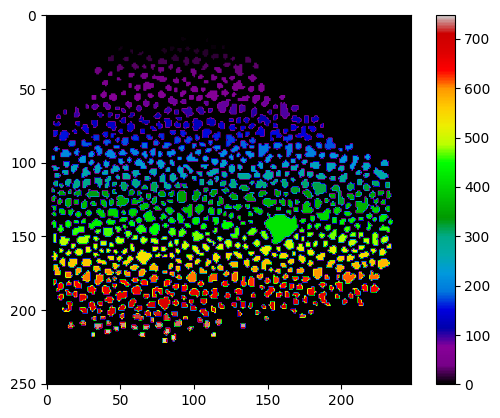

In [112]:
import numpy as np
from skimage.measure import block_reduce
from scipy import stats

def downscale_cluster_map(cluster_map, factor=2):
    """
    Downscale a cluster map by taking the most frequent value in each block.
    
    Parameters:
    -----------
    cluster_map : numpy.ndarray
        The input cluster map where each value is a cluster ID
    factor : int
        The downscaling factor (default: 2)
        
    Returns:
    --------
    numpy.ndarray
        The downscaled cluster map
    """
    h, w = cluster_map.shape
    new_h, new_w = h // factor, w // factor
    downscaled = np.zeros((new_h, new_w), dtype=cluster_map.dtype)
    
    for i in range(new_h):
        for j in range(new_w):
            # Extract the block
            block = cluster_map[i*factor:(i+1)*factor, j*factor:(j+1)*factor]
            # Find the most common value
            values, counts = np.unique(block, return_counts=True)
            downscaled[i, j] = values[np.argmax(counts)]
    
    return downscaled

num_pixels = data.shape[1] * data.shape[2]
frames = data.shape[0]
image_dim = [data.shape[1], data.shape[2]]

data_transposed = data.permute(1, 2, 0)

## The final cluster map has twice the dimensions of the input data so we have to reduce the dimenions again
downsampled_map = downscale_cluster_map(labeled_clusters, 1)
flat_clusters = torch.reshape(torch.from_numpy(downsampled_map), [num_pixels])

testing = downsampled_map.copy().astype(np.float32)

plt.imshow(testing, cmap='nipy_spectral')
plt.colorbar()



In [113]:
from data_utils.silhouette import get_silhouette_scores

data_to_use = data_transposed[:, :, :400]
silhouette_result  =get_silhouette_scores(data_to_use, downsampled_map, 6, 10)
## Calculate the distance between each pixel
# dist = pairwise_distances(reduced_data, reduced_data, metric='correlation', n_jobs=8)
# dist.shape

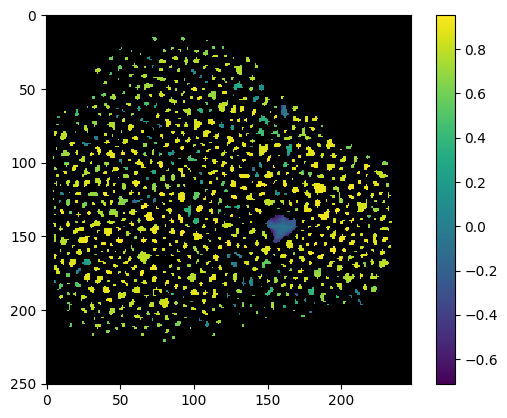

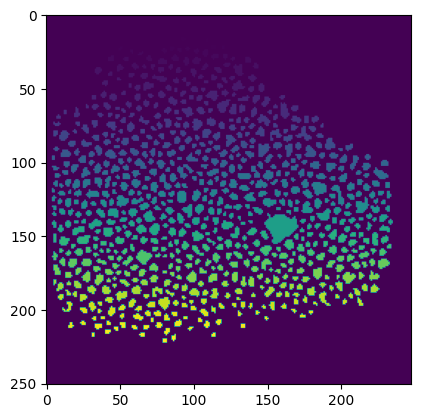

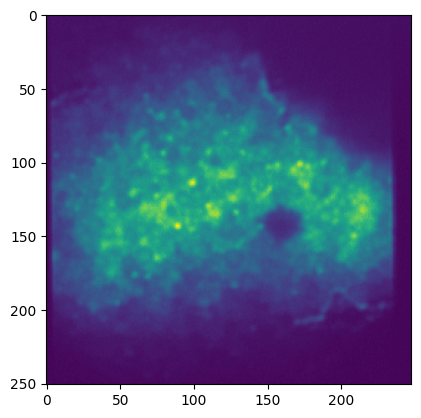

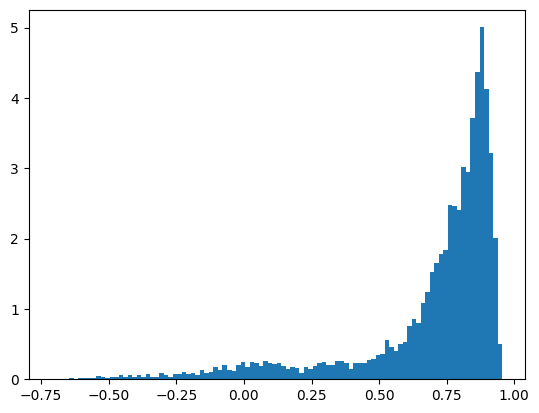

np.float64(0.6946100627955893)

In [114]:
not_clustered = downsampled_map == 0
clustered = downsampled_map > 0

# silhouette_result[not_clustered] = np.nan

cmap = plt.get_cmap('viridis').copy()  # Or use your preferred colormap
cmap.set_bad('black')  # Set NaN values to black

silhouette_copy = silhouette_result.copy()
silhouette_copy[~clustered] = np.nan
# silhouette_copy[~np.logical_and(silhouette_copy < 0.1, silhouette_copy > -0.1)] = np.nan

plt.imshow(silhouette_copy, cmap=cmap)
plt.colorbar()

plt.subplots()
plt.imshow(labeled_clusters)

plt.subplots()
plt.imshow(data_transposed[:,:,1])

plt.subplots()
plt.hist(silhouette_result[clustered], density=True, bins=100)
plt.show()

silhouette_result[clustered].mean()

In [115]:
return

## Profile FWHM
def get_fwhm_pos(data, peak_value):
    target = peak_value / 2
    
    last_value = peak_value
    for i in range(len(data)):
        value = data[i]

        if (value <= target):
            ## Lerp to find position of the peak
            weight = (target - last_value) / (value - last_value)
            fwhm_pos = i + weight

            return fwhm_pos
        
        last_value = value

    raise ValueError("No fwhm found")



def find_fwhm(peakpos, data, window=10):
    peak_value = data[peakpos]

    left_data = torch.flip(data[max(peakpos-window, 0):peakpos], [0])
    right_data = data[peakpos +1:max(peakpos+window, len(data))]

    left_pos = peakpos - get_fwhm_pos(left_data, peak_value)
    right_pos = peakpos + get_fwhm_pos(right_data, peak_value)
    
    return (left_pos, right_pos)


SyntaxError: 'return' outside function (2397719934.py, line 1)